In [1]:
import numpy as np
import mne
import os
from functools import partial 
import pandas as pd
import pickle

In [2]:
dir_name = '/scratch/jd5697/cv_project'

In [3]:
embeddings_train = np.load(os.path.join(dir_name, 'image_embeddings_vit_train_resplit.npy'), allow_pickle=True).item()
embeddings_test = np.load(os.path.join(dir_name, 'image_embeddings_vit_test_resplit.npy'), allow_pickle=True).item()
embeddings_test_small = np.load(os.path.join(dir_name, 'image_embeddings_vit_test_small_resplit.npy'), allow_pickle=True).item()

print(len(embeddings_train))
print(len(embeddings_test))
print(len(embeddings_test_small))
print(len(embeddings_train) + len(embeddings_test) + len(embeddings_test_small))

19848
2400
200
22448


In [4]:
# Assumes you downloaded the single trial responses in table format to this directory 
dir_name = '/scratch/jd5697/cv_project'

# and that you're interested in the data for the first subject
subs = ['01', '02', '03']

In [5]:
# Read files for each of the subjects and concat into one dataframe
dfs = []
for sub in subs:
    df = pickle.load(open(os.path.join(dir_name, 'sub-{}_responses_fmri_svd.pkl'.format(sub)), 'rb'))
    dfs.append(df)
df = pd.concat(dfs)

print(df.head())
print(df.shape)

  trial_type  session  run  subject_id  trial_id            stimulus  \
0      train        1    1           1         0         dog_12s.jpg   
1      train        1    1           1         1       mango_12s.jpg   
2      train        1    1           1         2     spatula_12s.jpg   
3       test        1    1           1         3  candelabra_14s.jpg   
4      train        1    1           1         4       panda_12s.jpg   

      concept                                                svd  
0         dog  [0.39951390732182984, 6.410602435125346, -1.15...  
1       mango  [-2.375556789045507, 2.7950678156120454, -0.97...  
2     spatula  [-2.4297802479278907, 5.386573114293661, -0.97...  
3  candelabra  [1.5577785519900746, 4.021682335479826, -1.027...  
4       panda  [1.3613456781789681, 3.224342354229859, 0.4323...  
(26220, 8)


In [6]:
print(df['stimulus'].value_counts())

stimulus
cockroach_09s.jpg       3
dog_12s.jpg             3
mango_12s.jpg           3
spatula_12s.jpg         3
blanket_09s.jpg         3
                       ..
shirt_12s.jpg           3
chicken_wire_12s.jpg    3
mango_13s.jpg           3
cow_12s.jpg             3
bib_12s.jpg             3
Name: count, Length: 8740, dtype: int64


In [7]:
def process_name(name):
    parts = name.split('/')
    filename = parts[-1]
    folder_name = '_'.join(filename.split('_')[:-1])
    result = f"{folder_name}/{filename}"
    return result

In [8]:
df['stimulus'] = df['stimulus'].apply(process_name)
df['stimulus'].head()

0                  dog/dog_12s.jpg
1              mango/mango_12s.jpg
2          spatula/spatula_12s.jpg
3    candelabra/candelabra_14s.jpg
4              panda/panda_12s.jpg
Name: stimulus, dtype: object

In [9]:
train_df = df[df['stimulus'].isin(embeddings_train.keys())]
test_df = df[df['stimulus'].isin(embeddings_test.keys())]
test_small_df = df[df['stimulus'].isin(embeddings_test_small.keys())]

print(train_df.shape)
print(test_df.shape)
print(test_small_df.shape)

(18720, 8)
(7200, 8)
(300, 8)


In [10]:
fmri_data_train = np.vstack(train_df['svd'])
fmri_data_test = np.vstack(test_df['svd'])
fmri_data_test_small = np.vstack(test_small_df['svd'])

print(fmri_data_train.shape)
print(fmri_data_test.shape)
print(fmri_data_test_small.shape)

(18720, 8740)
(7200, 8740)
(300, 8740)


In [11]:
embeddings_data_train = np.vstack([embeddings_train[key] for key in train_df['stimulus']])
embeddings_data_test = np.vstack([embeddings_test[key] for key in test_df['stimulus']])
embeddings_data_test_small = np.vstack([embeddings_test_small[key] for key in test_small_df['stimulus']])

print(embeddings_data_train.shape)
print(embeddings_data_test.shape)
print(embeddings_data_test_small.shape)

(18720, 768)
(7200, 768)
(300, 768)


In [12]:
from cuml.preprocessing import StandardScaler
scaler = StandardScaler()
fmri_data_train = scaler.fit_transform(fmri_data_train)
fmri_data_test = scaler.transform(fmri_data_test)
fmri_data_test_small = scaler.transform(fmri_data_test_small)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

In [14]:
# Define the neural network
class MLPRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

In [20]:
# Hyperparameters
input_size = fmri_data_train.shape[1]
output_size = embeddings_data_train.shape[1]
batch_size = 64
max_epochs = 5000
learning_rate = 0.003
patience = 2

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data
data_tensor = torch.tensor(fmri_data_train, dtype=torch.float32).to(device)
target_tensor = torch.tensor(embeddings_data_train, dtype=torch.float32).to(device)
dataset = TensorDataset(data_tensor, target_tensor)

# Split dataset into train and validation sets
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLPRegressor(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Learning rate schedule
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1 + 0.001 * epoch))

In [16]:
# Training loop
def train_model():
    best_val_loss = float('inf')
    patience_counter = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_targets).item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        # Update learning rate
        #scheduler.step()

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

Epoch [1/5000], Train Loss: 0.7820, Val Loss: 0.7756
Epoch [2/5000], Train Loss: 0.7531, Val Loss: 0.7632


Epoch [3/5000], Train Loss: 0.7255, Val Loss: 0.7511
Epoch [4/5000], Train Loss: 0.6991, Val Loss: 0.7395
Epoch [5/5000], Train Loss: 0.6740, Val Loss: 0.7283
Epoch [6/5000], Train Loss: 0.6501, Val Loss: 0.7174
Epoch [7/5000], Train Loss: 0.6272, Val Loss: 0.7069
Epoch [8/5000], Train Loss: 0.6054, Val Loss: 0.6967
Epoch [9/5000], Train Loss: 0.5846, Val Loss: 0.6868
Epoch [10/5000], Train Loss: 0.5647, Val Loss: 0.6772
Epoch [11/5000], Train Loss: 0.5458, Val Loss: 0.6680
Epoch [12/5000], Train Loss: 0.5276, Val Loss: 0.6590
Epoch [13/5000], Train Loss: 0.5103, Val Loss: 0.6504
Epoch [14/5000], Train Loss: 0.4938, Val Loss: 0.6420
Epoch [15/5000], Train Loss: 0.4780, Val Loss: 0.6338
Epoch [16/5000], Train Loss: 0.4629, Val Loss: 0.6259
Epoch [17/5000], Train Loss: 0.4485, Val Loss: 0.6183
Epoch [18/5000], Train Loss: 0.4347, Val Loss: 0.6109
Epoch [19/5000], Train Loss: 0.4215, Val Loss: 0.6037
Epoch [20/5000], Train Loss: 0.4089, Val Loss: 0.5968
Epoch [21/5000], Train Loss: 0.3969

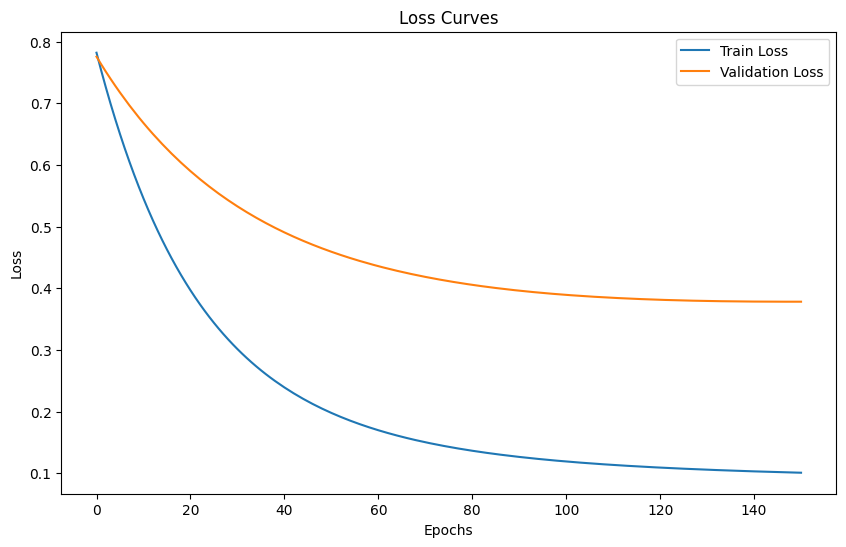

In [21]:
train_model()

In [22]:
def make_predictions(data):
    # Prepare test data
    test_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(test_tensor)
    return predictions.cpu().numpy()

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_top_k_accuracy(y_pred, y_true, k=5, num_participants=1):
    """Evaluate top-k accuracy using cosine similarity for embeddings."""
    num_indices = y_true.shape[0]/num_participants

    correct_predictions = 0

    for i in range(num_participants):
        y_pred_participant = y_pred[int(i*num_indices):int((i+1)*num_indices)]
        y_true_participant = y_true[int(i*num_indices):int((i+1)*num_indices)]
        n_samples = y_true_participant.shape[0]

        ## returns a n_samples X n_samples matrix
        similarity_matrix = cosine_similarity(y_pred_participant, y_true_participant)
        
        # Get the indices of the sorted similarities in descending order
        sorted_indices = np.argsort(-similarity_matrix, axis=1) #axis = 1 sorts across i.e. sorts across y_true for each pred
        
        # Check if the true index is within the top-k predictions for each sample
        for i in range(n_samples):
            if i in sorted_indices[i, :k]:
                correct_predictions += 1
    
    top_k_acc = correct_predictions / y_true.shape[0]
    return top_k_acc

In [24]:
top_5_acc = evaluate_top_k_accuracy(make_predictions(fmri_data_test), embeddings_data_test, k=5, num_participants=3)
print(f"Top-5 accuracy: {top_5_acc:.4f}")

Top-5 accuracy: 0.0019


In [25]:
top_5_acc = evaluate_top_k_accuracy(make_predictions(fmri_data_test_small), embeddings_data_test_small, k=5, num_participants=3)
print(top_5_acc)

0.03


In [26]:
top_5_acc = evaluate_top_k_accuracy(make_predictions(fmri_data_train), embeddings_data_train, k=5, num_participants=3)
print(top_5_acc)

0.7998397435897436


In [27]:
#Save the PyTorch model
torch.save(model.state_dict(), os.path.join(dir_name, 'fmri_mlp.pth'))

In [11]:
# embeddings_train_fmri_subset = {key: embeddings_train[key] for key in train_df['stimulus']}
# embeddings_test_fmri_subset = {key: embeddings_test[key] for key in test_df['stimulus']}
# embeddings_test_small_fmri_subset = {key: embeddings_test_small[key] for key in test_small_df['stimulus']}

# print(len(embeddings_train_fmri_subset))
# print(len(embeddings_test_fmri_subset))
# print(len(embeddings_test_small_fmri_subset))

6240
2400
100


In [14]:
# np.save(os.path.join(dir_name, 'image_embeddings_vit_train_fmri_subset.npy'), embeddings_train_fmri_subset)
# np.save(os.path.join(dir_name, 'image_embeddings_vit_test_fmri_subset.npy'), embeddings_test_fmri_subset)
# np.save(os.path.join(dir_name, 'image_embeddings_vit_test_small_fmri_subset.npy'), embeddings_test_small_fmri_subset)